In [2]:
import pandas as pd
import pm4py
from helpers import get_field_position
from pm4py.objects.ocel.util.log_ocel import log_to_ocel_multiple_obj_types as log_to_ocel

 Object Type         | Description                                                           
 ------------------- | --------------------------------------------------------------------- 
 `Team`              | The team associated with the event.                                   
 `From`              | The player in possession of the ball at the start of the event.       
 `To`                | The player in possession of the ball at the end of the event if the ownership changed.|
 `case:concept:name` | Unique ID for each case--an attack. 'AA' indicates away team attack, 'HA' indicates home team attack    
 `end_grid`          | The grid zone where the event ends.                              
 ------------------- | --------------------------------------------------------------------- 
 Attribute                      | Description                                               
 `attribute:subtype`            | Event subtype (e.g. `"PASS"`, `"GOAL"`, `"SHOT"`). For details please refer to the data documentation.     
 `attribute:start_x`, `start_y` | X/Y coordinates of the ball at the start of the event.        
 `attribute:end_x`, `end_y`     | X/Y coordinates of the ball at the end of the event.          
 `attribute:duration`           | Duration (in seconds) of the event.                           
 `attribute:travel_distance`    | Distance traveled by the ball.                                
 `attribute:start_grid`         | Grid ID where the event begins.                               
 `attribute:crossed_grid`       | If the event start in one grid and ends in another.           
 `attribute:attack_game`        | Identifier for attack sequence. Combined count of both team. 
 `attribute:attack_successful`  | Boolean flag — `True` if the attack led to a goal.            
 `attribute:home_team_score`    | Cumulative score of the home team at this point in the match.
 `attribute:away_team_score`    | Cumulative score of the away team at this point in the match. 


In [3]:
# settings
## Resolution of the grid
x_fields = 10
y_fields = 10

In [48]:
#load event data and preprocessing
df = pd.read_csv('sample-data\data\Sample_Game_1\Sample_Game_1_RawEventsData.csv')
#df['case:concept:name'] = df.index.astype(str)
df['timestamp'] = pd.to_datetime(df['Start Time [s]'], unit='s', origin='unix')
df['attribute:duration'] = df['End Time [s]'] - df['Start Time [s]']
#df['player']= df.apply(lambda row: [row["From"], row["To"]], axis=1)
df['attribute:travel_distance'] = ((df['End X'] - df['Start X'])**2 + (df['End Y'] - df['Start Y'])**2)**0.5
df['attribute:start_grid'] = df.apply(lambda row: [get_field_position(row["Start X"], row["Start Y"], x_fields=x_fields, y_fields=y_fields)], axis=1)
df['end_grid'] = df.apply(lambda row: [get_field_position(row["End X"], row["End Y"], x_fields=x_fields, y_fields=y_fields)], axis=1)
df['attribute:crossed_grid'] = df['attribute:start_grid'] != df['end_grid']
df['attribute:attack_game'] = ((df['Type'] == 'SET PIECE') | (df['Type'] == 'RECOVERY')).cumsum()

attack_id_away = 0
attack_id_home = 0
current_team = None
attack_ids = []
for i, row in df.iterrows():
    event = row['Type']
    if event in ['SET PIECE', 'RECOVERY']:
        current_team = row['Team']
        if current_team == 'Away':
            attack_id_away += 1
            attack_id = 'AA'+str(attack_id_away)
        else:
            attack_id_home += 1
            attack_id = 'HA'+str(attack_id_home)
    attack_ids.append(attack_id)

df['attack_team'] = attack_ids

df['attribute:attack_successful'] = False
goal_indices = df[df['Subtype'].str.endswith('GOAL', na=False)].index
successful_cases = df.loc[goal_indices, 'attack_team'].unique()
df.loc[df['attack_team'].isin(successful_cases), 'attribute:attack_successful'] = True

#rename columns
df.rename(columns={
    'Type': 'concept:name',
    'attack_team': 'case:concept:name',
    'timestamp': 'time:timestamp',
    'Subtype': 'attribute:subtype',
    'Start X': 'attribute:start_x',
    'Start Y': 'attribute:start_y',
    'End X': 'attribute:end_x',
    'End Y': 'attribute:end_y'
}, inplace=True)

#calculates team scores
df['home_goal'] = (
    df['attribute:subtype'].str.endswith('GOAL', na=False) &
    df['case:concept:name'].str.startswith('HA')
).astype(int)

df['away_goal'] = (
    df['attribute:subtype'].str.endswith('GOAL', na=False) &
    df['case:concept:name'].str.startswith('AA')
).astype(int)

df['attribute:home_team_score'] = df['home_goal'].cumsum()
df['attribute:away_team_score'] = df['away_goal'].cumsum()

df.drop(columns=['home_goal', 'away_goal'], inplace=True)
#df.to_csv('sample-data\data\Sample_Game_1\Sample_Game_1_RawEventsData_ocel.csv', index=False)

In [11]:
# load data from csvs
tracking_data_away_df = pd.read_csv('sample-data\data\Sample_Game_1\Sample_Game_1_RawTrackingData_Away_Team.csv', skiprows=2)
print('Tracking data away:')
print(tracking_data_away_df.columns)
tracking_data_home_df = pd.read_csv('sample-data\data\Sample_Game_1\Sample_Game_1_RawTrackingData_Home_Team.csv', skiprows=2)
print('Tracking data home:')
print(tracking_data_home_df.columns)

# reshape the tracking data to long format (one row per player per time point)
def reshape_tracking(df, team_label):
    long_rows = []
    for col in df.columns:
        if col.startswith("Player"):
            x_col = col
            y_col = f"Unnamed: {int(df.columns.get_loc(col)) + 1}"
            for _, row in df.iterrows():
                long_rows.append({
                    "Time [s]": row["Time [s]"],
                    "Frame": row["Frame"],
                    "Team": team_label.capitalize(),
                    #"Player": f"{team_label.capitalize()}_{col}",
                    "Player": f"{col}",
                    "X": row[x_col],
                    "Y": row[y_col]
                })
    return pd.DataFrame(long_rows)

tracking_long_home_df = reshape_tracking(tracking_data_home_df, "home")
tracking_long_away_df = reshape_tracking(tracking_data_away_df, "away")
tracking_long_df = pd.concat([tracking_long_home_df, tracking_long_away_df])

# add grid position to tracking long
tracking_long_df['Grid Position'] = tracking_long_df.apply(lambda row: get_field_position(row['X'], row['Y'], x_fields=x_fields, y_fields=y_fields), axis=1)

# identify only events when grid position of player changes
def get_grid_change_events(tracking_df):
    tracking_df = tracking_df.sort_values(by=['Player', 'Time [s]'])
    tracking_df['Prev Grid Position'] = tracking_df.groupby('Player')['Grid Position'].shift(1)
    grid_change_events = tracking_df[tracking_df['Grid Position'] != tracking_df['Prev Grid Position']]
    grid_change_events.rename(columns={'Grid Position': 'To Position', 
                                'Prev Grid Position': 'From Position'}, inplace=True
                       )
    return grid_change_events

tracking_grid_change_events_df = get_grid_change_events(tracking_long_df)

Tracking data away:
Index(['Period', 'Frame', 'Time [s]', 'Player25', 'Unnamed: 4', 'Player15',
       'Unnamed: 6', 'Player16', 'Unnamed: 8', 'Player17', 'Unnamed: 10',
       'Player18', 'Unnamed: 12', 'Player19', 'Unnamed: 14', 'Player20',
       'Unnamed: 16', 'Player21', 'Unnamed: 18', 'Player22', 'Unnamed: 20',
       'Player23', 'Unnamed: 22', 'Player24', 'Unnamed: 24', 'Player26',
       'Unnamed: 26', 'Player27', 'Unnamed: 28', 'Player28', 'Unnamed: 30',
       'Ball', 'Unnamed: 32'],
      dtype='object')
Tracking data home:
Index(['Period', 'Frame', 'Time [s]', 'Player11', 'Unnamed: 4', 'Player1',
       'Unnamed: 6', 'Player2', 'Unnamed: 8', 'Player3', 'Unnamed: 10',
       'Player4', 'Unnamed: 12', 'Player5', 'Unnamed: 14', 'Player6',
       'Unnamed: 16', 'Player7', 'Unnamed: 18', 'Player8', 'Unnamed: 20',
       'Player9', 'Unnamed: 22', 'Player10', 'Unnamed: 24', 'Player12',
       'Unnamed: 26', 'Player13', 'Unnamed: 28', 'Player14', 'Unnamed: 30',
       'Ball', 'Unna

C:\Users\Vito\AppData\Local\Temp\ipykernel_19288\1947953385.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_change_events.rename(columns={'Grid Position': 'To Position',


In [61]:
# format dataframe for ocel
def format_ocel_df(tracking_df):
    ocel_df = tracking_df.copy()
    ocel_df['concept:name'] = f"Player changes position"
    ocel_df['time:timestamp'] = pd.to_datetime(ocel_df['Time [s]'], unit='s')
    ocel_df['crossed_grid'] = True
    ocel_df['To']=None

    ocel_df.rename(columns={
    #'attack_team': 'case:concept:name',
    #'Subtype': 'attribute:subtype', can be the direction of the movement
    'X': 'attribute:end_x',
    'Y': 'attribute:end_y',
    'From Position': 'attribute:start_grid',
    'To Position': 'end_grid',
    'Player': 'From',
    }, inplace=True)
    
    return ocel_df

ocel_df = format_ocel_df(tracking_grid_change_events_df)

In [ ]:
import numpy as np
df = df.sort_values('time:timestamp').reset_index(drop=True)
ocel_df = ocel_df.sort_values('time:timestamp').reset_index(drop=True)

# Columns to copy
cols_to_fill = [
    'case:concept:name', 
    'attribute:attack_game', 
    'attribute:attack_successful',
    'attribute:home_team_score', 
    'attribute:away_team_score'
]

for col in cols_to_fill:
    ocel_df[col] = None


timestamps_large = df['time:timestamp'].to_numpy(dtype='datetime64[ns]')

for i, row in ocel_df.iterrows():
    ts = np.datetime64(row['time:timestamp']) 
    pos = timestamps_large.searchsorted(ts, side='right') - 1 
    if pos >= 0:
        for col in cols_to_fill:
            ocel_df.at[i, col] = df.at[pos, col]
final_df = pd.concat([df, ocel_df], ignore_index=True).sort_values('time:timestamp')

In [65]:
final_df=final_df.reset_index(drop=True)
pd.set_option('display.max_columns', None)
final_df

,Team,concept:name,attribute:subtype,Period,Start Frame,Start Time [s],End Frame,End Time [s],From,To,attribute:start_x,attribute:start_y,attribute:end_x,attribute:end_y,time:timestamp,attribute:duration,attribute:travel_distance,attribute:start_grid,end_grid,attribute:crossed_grid,attribute:attack_game,case:concept:name,attribute:attack_successful,attribute:home_team_score,attribute:away_team_score,Time [s],Frame,crossed_grid
0,Away,SET PIECE,KICK OFF,1.0,1.0,0.04,0.0,0.0,Player19,NaN,NaN,NaN,NaN,NaN,1970-01-01 00:00:00.040,-0.04,NaN,[None],[None],False,1,AA1,False,0,0,NaN,NaN,NaN
1,Home,Player changes position,NaN,NaN,NaN,NaN,NaN,NaN,Player5,None,NaN,NaN,0.41094,0.72589,1970-01-01 00:00:00.040,NaN,NaN,NaN,E8,NaN,1,AA1,False,0,0,0.04,1.0,True
2,Home,Player changes position,NaN,NaN,NaN,NaN,NaN,NaN,Player9,None,NaN,NaN,0.52697,0.37980,1970-01-01 00:00:00.040,NaN,NaN,NaN,F4,NaN,1,AA1,False,0,0,0.04,1.0,True
3,Home,Player changes position,NaN,NaN,NaN,NaN,NaN,NaN,Player6,None,NaN,NaN,0.41698,0.47843,1970-01-01 00:00:00.040,NaN,NaN,NaN,E5,NaN,1,AA1,False,0,0,0.04,1.0,True
4,Away,Player changes position,NaN,NaN,NaN,NaN,NaN,NaN,Player18,None,NaN,NaN,0.40783,0.61525,1970-01-01 00:00:00.040,NaN,NaN,NaN,E7,NaN,1,AA1,False,0,0,0.04,1.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904118,Home,Player changes position,NaN,NaN,NaN,NaN,NaN,NaN,Player1,None,NaN,NaN,NaN,NaN,1970-01-01 01:36:40.240,NaN,NaN,None,None,NaN,355,AA175,False,4,0,5800.24,145006.0,True
904119,Home,Player changes position,NaN,NaN,NaN,NaN,NaN,NaN,Player6,None,NaN,NaN,NaN,NaN,1970-01-01 01:36:40.240,NaN,NaN,None,None,NaN,355,AA175,False,4,0,5800.24,145006.0,True
904120,Away,Player changes position,NaN,NaN,NaN,NaN,NaN,NaN,Player19,None,NaN,NaN,NaN,NaN,1970-01-01 01:36:40.240,NaN,NaN,None,None,NaN,355,AA175,False,4,0,5800.24,145006.0,True
904121,Away,Player changes position,NaN,NaN,NaN,NaN,NaN,NaN,Player22,None,NaN,NaN,NaN,NaN,1970-01-01 01:36:40.240,NaN,NaN,None,None,NaN,355,AA175,False,4,0,5800.24,145006.0,True


In [67]:
#df = pm4py.format_dataframe(df, case_id='case:concept:name', activity_key='Activity', timestamp_key='Timestamp')
event_log = pm4py.convert_to_event_log(final_df)

In [68]:
ocel= log_to_ocel(event_log, activity_column='concept:name'
                  , timestamp_column='time:timestamp', obj_types=['Team','From', 'To','case:concept:name', 'end_grid']
                  ,additional_event_attributes=['attribute:subtype', 'attribute:start_x', 'attribute:start_y'
                                                , 'attribute:end_x', 'attribute:end_y' 
                                                , 'attribute:duration', 'attribute:travel_distance', 'attribute:start_grid'
                                                , 'attribute:crossed_grid', 'attribute:attack_game', 'attribute:attack_successful'
                                                , 'attribute:home_team_score', 'attribute:away_team_score'                                                
                                                ])

In [ ]:
pd.set_option('display.max_columns', None)
ocel.get_extended_table()

,ocel:eid,ocel:activity,ocel:timestamp,attribute:subtype,attribute:duration,attribute:start_grid,attribute:crossed_grid,attribute:attack_game,attribute:attack_successful,attribute:home_team_score,...,attribute:end_x,attribute:end_y,attribute:start_x,attribute:start_y,attribute:travel_distance,ocel:type:Team,ocel:type:From,ocel:type:case:concept:name,ocel:type:end_grid,ocel:type:To
0,0,SET PIECE,1970-01-01 00:00:00.040,KICK OFF,-0.04,[None],False,1,False,0,...,NaN,NaN,NaN,NaN,NaN,[Away],[Player19],[AA1],NaN,NaN
1,1,Player changes position,1970-01-01 00:00:00.040,NaN,NaN,NaN,NaN,1,False,0,...,0.41094,0.72589,NaN,NaN,NaN,[Home],[Player5],[AA1],[E8],NaN
2,2,Player changes position,1970-01-01 00:00:00.040,NaN,NaN,NaN,NaN,1,False,0,...,0.52697,0.37980,NaN,NaN,NaN,[Home],[Player9],[AA1],[F4],NaN
3,3,Player changes position,1970-01-01 00:00:00.040,NaN,NaN,NaN,NaN,1,False,0,...,0.41698,0.47843,NaN,NaN,NaN,[Home],[Player6],[AA1],[E5],NaN
4,4,Player changes position,1970-01-01 00:00:00.040,NaN,NaN,NaN,NaN,1,False,0,...,0.40783,0.61525,NaN,NaN,NaN,[Away],[Player18],[AA1],[E7],NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904118,904118,Player changes position,1970-01-01 01:36:40.240,NaN,NaN,NaN,NaN,355,False,4,...,NaN,NaN,NaN,NaN,NaN,[Home],[Player1],[AA175],NaN,NaN
904119,904119,Player changes position,1970-01-01 01:36:40.240,NaN,NaN,NaN,NaN,355,False,4,...,NaN,NaN,NaN,NaN,NaN,[Home],[Player6],[AA175],NaN,NaN
904120,904120,Player changes position,1970-01-01 01:36:40.240,NaN,NaN,NaN,NaN,355,False,4,...,NaN,NaN,NaN,NaN,NaN,[Away],[Player19],[AA175],NaN,NaN
904121,904121,Player changes position,1970-01-01 01:36:40.240,NaN,NaN,NaN,NaN,355,False,4,...,NaN,NaN,NaN,NaN,NaN,[Away],[Player22],[AA175],NaN,NaN


In [6]:
path = "game1.jsonocel"
pm4py.write_ocel(ocel, path)

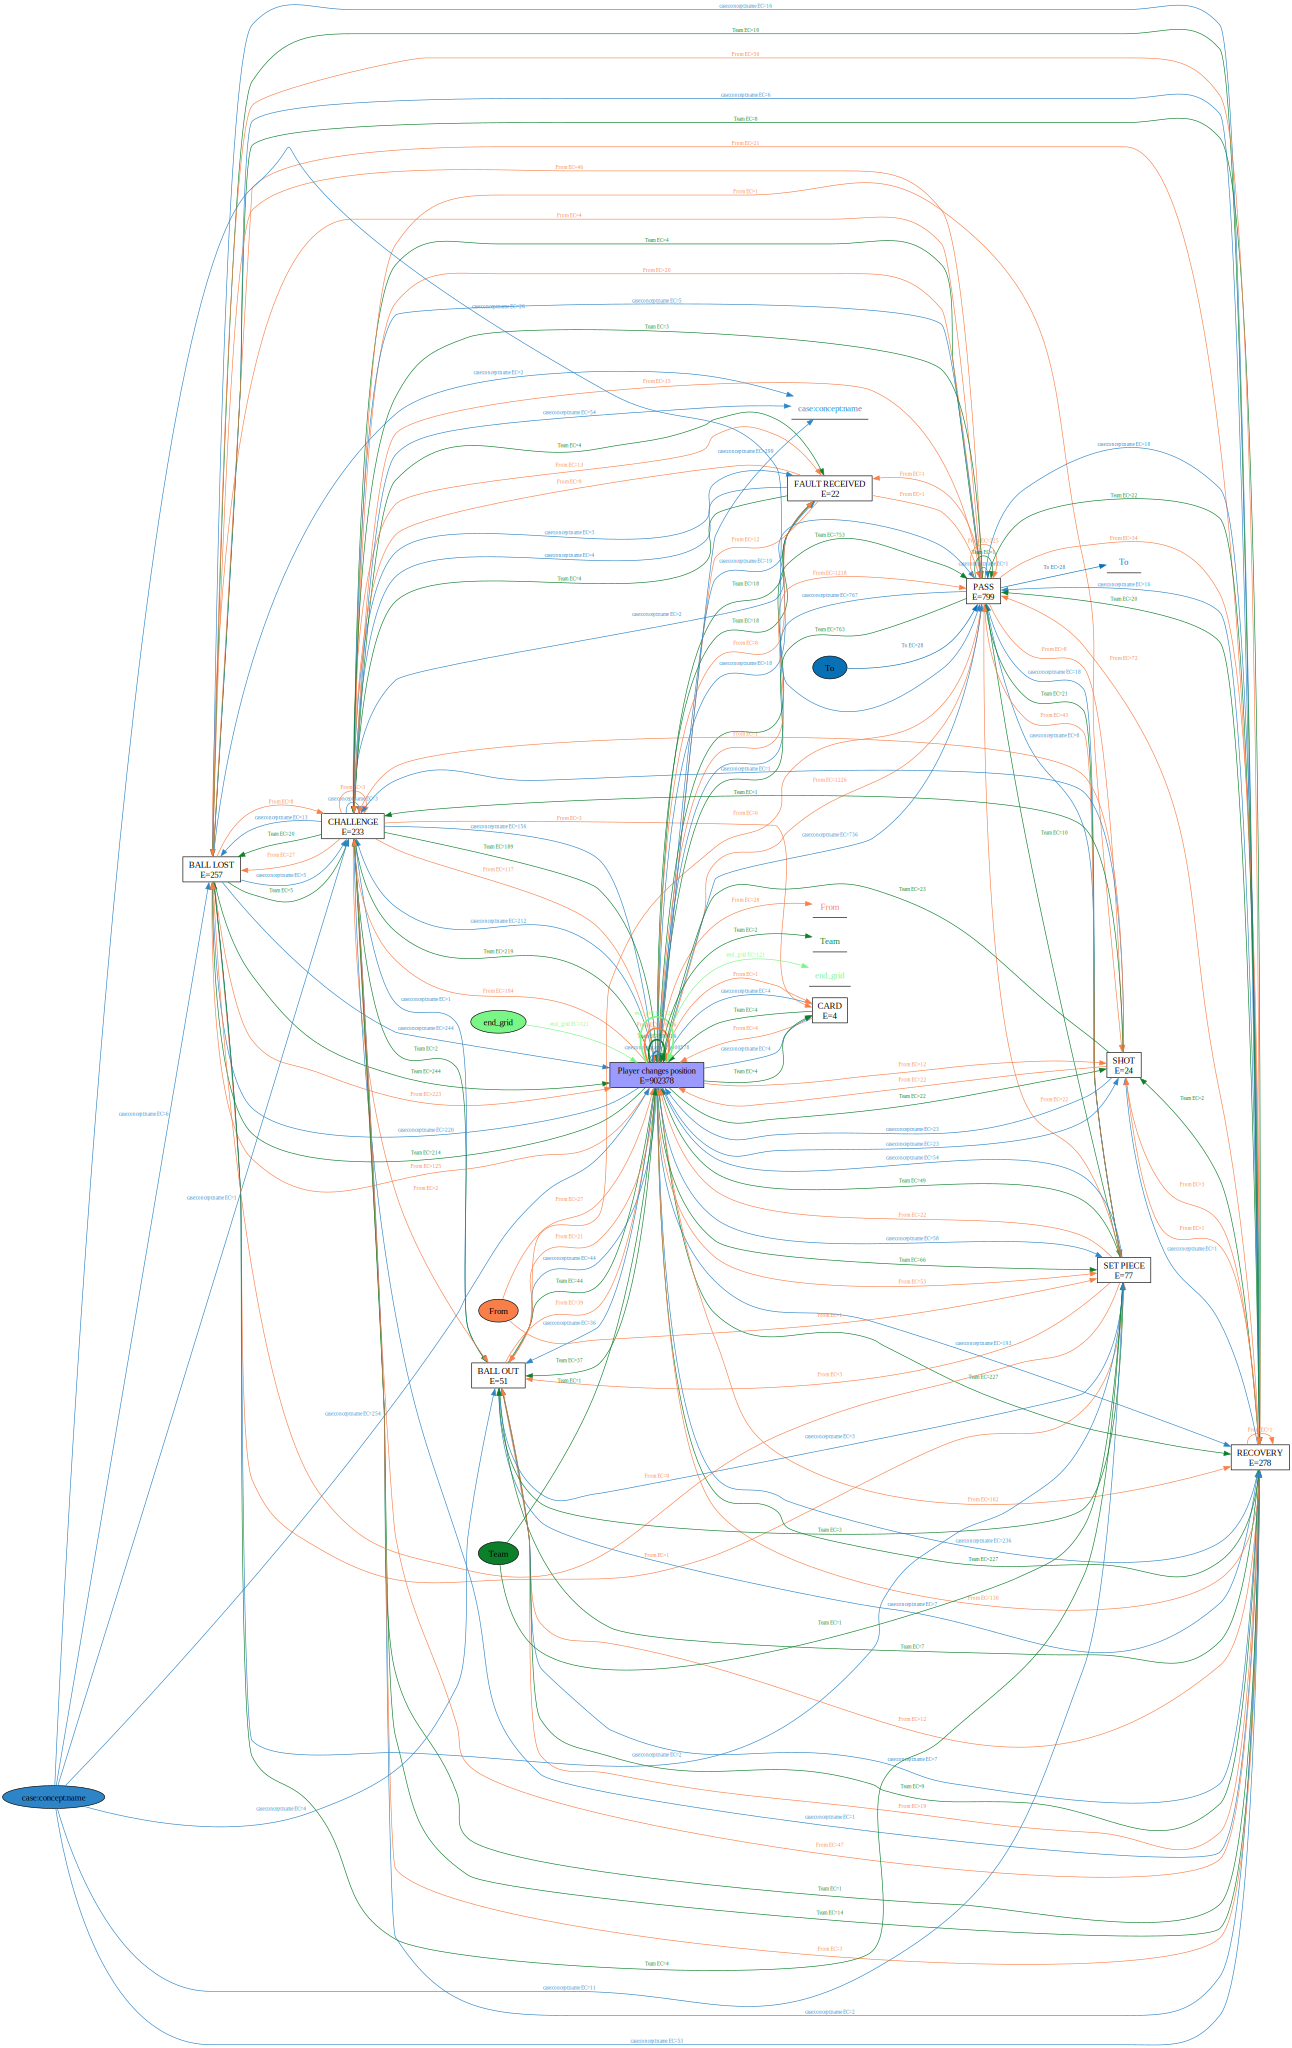

In [69]:
dfg=pm4py.ocel.discover_ocdfg(ocel)
pm4py.visualization.ocel.ocdfg.visualizer.apply(dfg)